In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
# Step 1: Load data

db_url = (
    f"postgresql+psycopg2://{os.environ['DB_USERNAME']}:{os.environ['DB_PASSWORD']}@{os.environ['DB_LOCALHOST']}:{os.environ['DB_PORT']}/{os.environ['DB_NAME']}"
)
engine = create_engine(db_url)
df = pd.read_sql_query("SELECT * FROM housing", con=engine)

X: pd.DataFrame = df.drop(columns=["medv", "id"])
y: pd.Series = df["medv"]

print(X.iloc[:5])

      crim    zn  indus    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  chas  
0  396.90   4.98   0.0  
1  396.90   9.14   0.0  
2  392.83   4.03   0.0  
3  394.63   2.94   0.0  
4  396.90    NaN   0.0  


In [5]:
# Step 2: Split data into training and test data

SPLIT_PORTION: float = 0.8
split_point: int = int(len(df) * SPLIT_PORTION)

X_train: np.ndarray = X.iloc[:split_point].to_numpy()
X_test: np.ndarray = X.iloc[split_point:].to_numpy()
y_train: np.ndarray = y.iloc[:split_point].to_numpy()
y_test: np.ndarray = y.iloc[split_point:].to_numpy()

X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0

In [6]:
# Step 3: Cost function

def my_mean_squared_error(predictions: np.ndarray, actual: np.ndarray) -> float:
    return (1 / (2 * len(predictions))) * np.sum(np.square(predictions - actual))


In [7]:
# Step 4: Scale features using Z-score normalisation

training_mean: list[float] = X_train.mean(axis=0)
training_std: list[float] = X_train.std(axis=0)
training_std[training_std == 0] = 1  # prevents dividing by 0

X_train = (X_train - training_mean) / training_std
X_test = (X_test - training_mean) / training_std


In [8]:
# Step 5: Gradient descent

def gradient_descent(
        w: np.ndarray, 
        b: float, 
        learning_rate: float, 
        X_train: np.ndarray, 
        y_train: np.ndarray,
        regularisation_param: float = 0
    ) -> tuple[np.ndarray, float, float]:
    m: int = X_train.shape[0]  # num examples
    
    y_pred = np.dot(X_train, w) + b
    loss = my_mean_squared_error(y_pred, y_train) + (regularisation_param / (2 * m)) * np.sum(np.square(w))
    grad_w = (1 / m) * np.dot(y_pred - y_train, X_train)
    grad_b = (1 / m) * np.sum(y_pred - y_train)
    
    new_w = w - learning_rate * grad_w
    new_b = b - learning_rate * grad_b
    
    return new_w, new_b, loss

In [9]:
# Step 6: Run gradient descent with automatic convergence testing to get good values for w and b

LEARNING_RATE: float = 0.01
NUM_ITERS: int = 10_001
EPSILON: float = 1e-5
REGULARISATION_PARAM: float = 3

w: np.ndarray = np.zeros(X.shape[1])
b: float = 0

results: list[tuple[int, float]] = []

for i in range(NUM_ITERS):
    w, b, loss = gradient_descent(w, b, LEARNING_RATE, X_train, y_train, REGULARISATION_PARAM)
    results.append((i, loss))

    if len(results) > 1 and abs(results[i-1][1] - loss) < EPSILON:
        print(f"Convergence reached after {i} iterations")
        break

    if i % 100 == 0:
        print(f"Iteration {i}: {loss}")


Iteration 0: 335.01047029702966
Iteration 100: 53.61873663722581
Iteration 200: 18.202762992625754
Iteration 300: 13.358497272037319
Iteration 400: 12.605715557713664
Iteration 500: 12.430071630739
Iteration 600: 12.35287695109311
Iteration 700: 12.303597068885646
Iteration 800: 12.268482873105784
Iteration 900: 12.242748311699017
Iteration 1000: 12.223696565285781
Iteration 1100: 12.209511452501104
Iteration 1200: 12.198908605441487
Iteration 1300: 12.190963662864732
Iteration 1400: 12.185004155851246
Iteration 1500: 12.180536437018993
Iteration 1600: 12.177195142006944
Iteration 1700: 12.174707801712005
Iteration 1800: 12.172869815373007
Iteration 1900: 12.17152658544088
Convergence reached after 1940 iterations


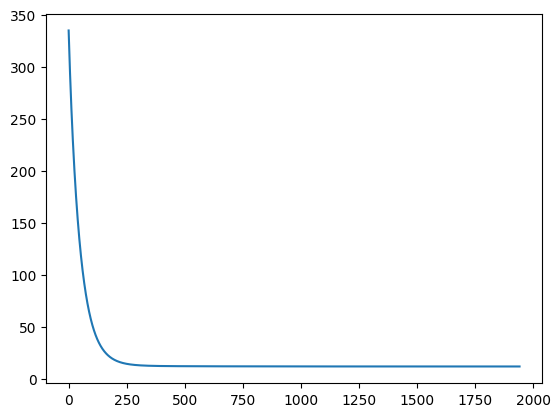

In [10]:
# Step 7: Visualise the cost of each iteration of gradient descent

x_vals, y_vals = zip(*results)
plt.plot(x_vals, y_vals)

In [11]:
# Step 8: Predict on training set

y_test_pred = np.dot(X_test, w) + b
abs_error = np.abs(y_test_pred - y_test)

print(f"Smallest Error: {min(abs_error)}")
print(f"Largest Error: {max(abs_error)}")
print(f"Average Error: {np.mean(abs_error)}")

Smallest Error: 0.007448707643568753
Largest Error: 13.30817245864534
Average Error: 4.788474250952781


In [12]:
# Step 9: Store weights and bias in db
query = text("""
    INSERT INTO model_params (
        weights, bias, learning_rate, num_iterations,
        regularisation_param, convergence_limit,
        training_mean, training_std
    )
    VALUES (:weights, :bias, :lr, :num_iters, :reg_param, :epsilon, :train_mean, :train_std)
""")

with engine.connect() as conn:
    conn.execute(query, {
        "weights": w.tolist(),
        "bias": float(b),
        "lr": float(LEARNING_RATE),
        "num_iters": int(NUM_ITERS),
        "reg_param": float(REGULARISATION_PARAM),
        "epsilon": float(EPSILON),
        "train_mean": list(training_mean),
        "train_std": list(training_std),
    })
    conn.commit()